In [1]:
VERSION

v"1.8.2"

In [2]:
ENV["COLUMNS"] = 1000
ENV["LINES"] = 20;

In [3]:
# using Pkg
# module_name = "ScatteredInterpolation"
# Pkg.add(module_name)
# Pkg.update(module_name)
# Pkg.build(module_name)

In [4]:
using DataFrames
using GLMakie
using JLD2

using Revise
using Astroshaper
import SPICE

In [5]:
meta_kernel = "/Users/masanorikanamaru/Dropbox/spice/hera/kernels/mk/hera_study_PO_EMA_2024_shapeViewer.tm"

SPICE.furnsh(meta_kernel)

In [6]:
et_start = SPICE.utc2et("2027-02-09T22:00:00")
et_end   = SPICE.utc2et("2027-02-10T22:00:00")
step     = 3600/10

et_range = et_start:step:et_end

@show et_range
@show length(et_range);

et_range = 8.554824691849957e8:360.0:8.555688691849957e8
length(et_range) = 241


In [7]:
# save_range = findall(et_range .> et_range[end] - 7.63262 * 3600)
save_range = 1:length(et_range)

@show save_range[begin]
@show save_range[end]
@show length(save_range);

save_range[begin] = 1
save_range[end] = 241
length(save_range) = 241


In [8]:
sun_d1 = spkpos("SUN",       et_range, "DIDYMOS_FIXED",   "None", "DIDYMOS")
sun_d2 = spkpos("SUN",       et_range, "DIMORPHOS_FIXED", "None", "DIMORPHOS")
d1_d2  = spkpos("DIDYMOS",   et_range, "DIMORPHOS_FIXED", "None", "DIMORPHOS")
d2_d1  = spkpos("DIMORPHOS", et_range, "DIDYMOS_FIXED",   "None", "DIDYMOS");

In [9]:
D1_TO_D2 = pxform("DIDYMOS_FIXED",   "DIMORPHOS_FIXED", et_range)
D2_TO_D1 = pxform("DIMORPHOS_FIXED", "DIDYMOS_FIXED",   et_range)

D1_TO_J2000 = pxform("DIDYMOS_FIXED",   "J2000", et_range)
D2_TO_J2000 = pxform("DIMORPHOS_FIXED", "J2000", et_range);

In [10]:
SPICE.kclear()

In [11]:
# fig = Figure()
# ax = Axis3(fig[1, 1], aspect=:data)

# scatter!([r[1] for r in sun_d1], [r[2] for r in sun_d1], [r[3] for r in sun_d1], color=:orange, size=2)

# display(fig)

# Shape Models: Didymos & Dimorphos

In [47]:
shapedir = "/Users/masanorikanamaru/Dropbox/spice/hera/kernels/dsk"

shapepath1 = joinpath(shapedir, "g_50677mm_rad_obj_dida_0000n00000_v001.obj")
shapepath2 = joinpath(shapedir, "g_06650mm_rad_obj_didb_0000n00000_v001.obj")

shape1 = ShapeModel(shapepath1; scale=1000, find_visible_facets=true, save_shape=false)
shape2 = ShapeModel(shapepath2; scale=1000, find_visible_facets=true, save_shape=false)
shapes = (shape1, shape2);

In [52]:
println(shapes[1])
println(shapes[2])

Shape model
-----------
Nodes             : 1000
Faces             : 1996
Surface area      : 1.9587914739775867e6
Volume            : 2.485481753075182e8
Equivalent radius : 390.03836143582186
Center-of-Figure  : [2.484674354494825e-6, -2.0997384259416257e-6, 2.190089591373722e-6]
Inertia tensor    : 
    | Ixx Ixy Ixz |   [0.0, 0.0, 0.0]
    | Iyx Iyy Iyz | = [0.0, 0.0, 0.0]
    | Izx Izy Izz |   [0.0, 0.0, 0.0]

Shape model
-----------
Nodes             : 1538
Faces             : 3072
Surface area      : 53920.630657525166
Volume            : 1.1314114665400542e6
Equivalent radius : 64.64138537338498
Center-of-Figure  : [2.009646200056278e-16, 3.5852088209004e-16, -2.9131831316015805e-15]
Inertia tensor    : 
    | Ixx Ixy Ixz |   [0.0, 0.0, 0.0]
    | Iyx Iyy Iyz | = [0.0, 0.0, 0.0]
    | Izx Izy Izz |   [0.0, 0.0, 0.0]



# TPM only on Didymos

In [14]:
thermo_params = ThermoParams(  # [Michel+2016; Naidu+2020]
    A_B   = 0.059,  # Bolometric  Bond albedo
    A_TH  = 0.0,
    k     = 0.125,
    ρ     = 2170.,
    Cp    = 600.,
    ϵ     = 0.9,
    t_bgn = et_range[begin],
    t_end = et_range[end],
    Nt    = length(et_range),
    z_max = 0.6,
    Nz    = 41,
    P     = SPICE.convrt(DIDYMOS[:P], "hours", "seconds"),
)

Thermophysical parameters
-------------------------
A_B   : 0.059
A_TH  : 0.0
k     : 0.125
ρ     : 2170.0
Cp    : 600.0
ϵ     : 0.9
-------------------------
t_bgn : 8.554824691849957e8
t_bgn : 105180.37410616312 (Normalized by period P)
t_end : 8.555688691849957e8
t_end : 105190.99686542484 (Normalized by period P)
Nt    : 241
Δt    : 360.0000000001112
Δt    : 0.044261496923839634 (Normalized by period P)
-------------------------
z_max : 0.6
z_max : 6.057014348123621 (Normalized by skin depth l)
Nz    : 41
Δz    : 0.015
Δz    : 0.15142535870309054 (Normalized by skin depth l)
-------------------------
P     : 8133.4800000000005
l     : 0.09905870541414048
Γ     : 403.4228550788862
λ     : 0.15360983102923334
-------------------------


In [15]:
savepath = "tmp.jld2"
run_TPM!(shape1, et_range, sun_d1, thermo_params, savepath, save_range)

jldopen(savepath, "r+") do file
    file["D1_TO_J2000"] = D1_TO_J2000[save_range]
end;

0.004908200959444313
0.008440054943300192
0.0120891306916738
0.015479726455203796
0.018105898323619845
0.02022211117218463
0.022302482592344165
0.023993298923428767
0.02507001673936443
0.025161856581598495
0.025226459932493065
0.025655241399176316
0.025944991777380803
0.02606253710843004
0.02633656932021363
0.02676760435978366
0.02722850229552078
0.02850008826171463
0.03005313282160656
0.03149456711492343
0.03248836548624546
0.03330803859327788
0.035121587741316226
0.03789245204501958
0.04084543817002062
0.043727942454751756
0.046360235124897495
0.048515426278286054
0.051001378912751555
0.05395117596392233
0.05624509368856626
0.057264118605862765
0.0573989129080692
0.05802424120096614
0.05893229372801653
0.05937307391267671
0.059604641720430195
0.06064644114766941
0.061651409240015186
0.06327538097533522
0.06557746794431314
0.06732309138818
0.068426080099693
0.06806284647983474
0.06805704642932821
0.06982009055907691
0.07194319698751205
0.07429277548125007
0.07702046909489069
0.0791214

0.1615303114344711
0.1618332073052682
0.1638534280756038
0.16519827533751433
0.16532060898207523
0.1659315905338997
0.16878760262880313
0.1709034417779111
0.17454925455249937
0.17783888941576442
0.1790949047359582
0.17857916242269845
0.17520987778536692
0.17308622091052003
0.17346835905504723
0.17342250244681656
0.17387439545080127
0.17588586933160463
0.1771513582650249
0.1803249381879716
0.1866500130855967
0.19231868889755457
0.19511846298641067
0.19413134760618547
0.19513187257111084
0.19793403491466746
0.1985341427735009
0.1980991610300076
0.1997364753861443
0.20285070631444418
0.20530278452440534
0.2097641104318866
0.21255717263333046
0.2129222699711341
0.21029899049923356
0.2063732425606904
0.2050942986286046
0.20496774501404705
0.20432720765332843
0.20476092250017133
0.2062184528414495
0.20820172045489152
0.21293108873999214
0.21987387517680917
0.22475152605998097
0.2257592724567216
0.22542063911590066
0.2271910173087946
0.22906054598179107
0.22909724911136095
0.22920853741918423

0.2818386643883053
0.2844483689185169
0.284373978678143
0.2836570845798647
0.28622657194205847
0.28907047440757067
0.292523850183371
0.29766367443317815
0.3000270330385778
0.2994327107261004
0.29404991086271787
0.2890184876585402
0.2878633259684351
0.28637128635834597
0.2843833363240126
0.28435546723913585
0.28488679264114597
0.28696163114034423
0.29360371669622304
0.30183086342116405
0.3063159101826163
0.3057193335852628
0.305283426423836
0.3079957841827862
0.30898914360037816
0.30797516747858134
0.30820325260974785
0.3120500973806994
0.3142273422262713
0.3193260690964839
0.3234345313473845
0.3242344011624315
0.322332746596633
0.3158717666309642
0.31170512647303844
0.31097391581443395
0.3085243989532202
0.30663050908268163
0.30764064723076023
0.30773677459759097
0.311305750564581
0.32004539251541286
0.3275217480750224
0.3305975613503759
0.32783779900665466
0.3284238211093887
0.33178865413855363
0.3316370326483525
0.3299756087593143
0.3317496632591109


In [16]:
# draw(shape1; data=:temperature, colormap=:vik)

In [17]:
data = load("tmp.jld2");

In [18]:
# data["shape"]
# data["et_range"]
# data["sun"]
# data["thermo_params"]
# data["surf_temps"]
# data["forces"]
# data["torques"]

# data["D1_TO_J2000"]

# TPM only on Dimorphos

In [ ]:
thermo_params = ThermoParams(  # [Michel+2016; Naidu+2020]
    A_B   = 0.059,  # Bolometric  Bond albedo
    A_TH  = 0.0,
    k     = 0.125,
    ρ     = 2170.,
    Cp    = 600.,
    ϵ     = 0.9,
    t_bgn = et_range[begin],
    t_end = et_range[end],
    Nt    = length(et_range),
    z_max = 0.6,
    Nz    = 41,
    P     = SPICE.convrt(DIDYMOS[:P], "hours", "seconds"),
);

In [ ]:
savepath = "tmp.jld2"
run_TPM!(shape2, et_range, sun_d2, thermo_params, savepath, save_range)

jldopen(savepath, "r+") do file
    file["D2_TO_J2000"] = D2_TO_J2000[save_range]
end;

In [ ]:
draw(shape2; data=:temperature, colormap=:vik)

# TPM on Binary Asteroid

In [53]:
thermo_params = ThermoParams(  # [Michel+2016; Naidu+2020]
    A_B   = 0.059,  # Bolometric  Bond albedo
    A_TH  = 0.0,
    k     = 0.125,
    ρ     = 2170.,
    Cp    = 600.,
    ϵ     = 0.9,
    t_bgn = et_range[begin],
    t_end = et_range[end],
    Nt    = length(et_range),
    z_max = 0.6,
    Nz    = 41,
    P     = SPICE.convrt(DIDYMOS[:P], "hours", "seconds"),
);

In [55]:
savepath = "tmp.jld2"
run_TPM!(shapes, et_range, (sun_d1, sun_d2), D2_TO_D1, d2_d1, thermo_params, savepath, save_range)

# jldopen(savepath, "r+") do file
#     file["D2_TO_J2000"] = D2_TO_J2000[save_range]
# end;

In [56]:
# draw(shape1; data=:temperature, colormap=:vik)
# draw(shape2; data=:temperature, colormap=:vik)

In [57]:
data = load("tmp.jld2")
keys(data)

KeySet for a Dict{String, Any} with 8 entries. Keys:
  "et_range"
  "suns"
  "S2P"
  "thermo_params"
  "forces"
  "shapes"
  "surf_temps"
  "torques"

In [58]:
# data["shapes"]
# data["et_range"]
# data["suns"][1]
# data["thermo_params"]
# data["surf_temps"][1]
# data["forces"]
# data["torques"]

# data["D1_TO_J2000"]

# Temperature Map

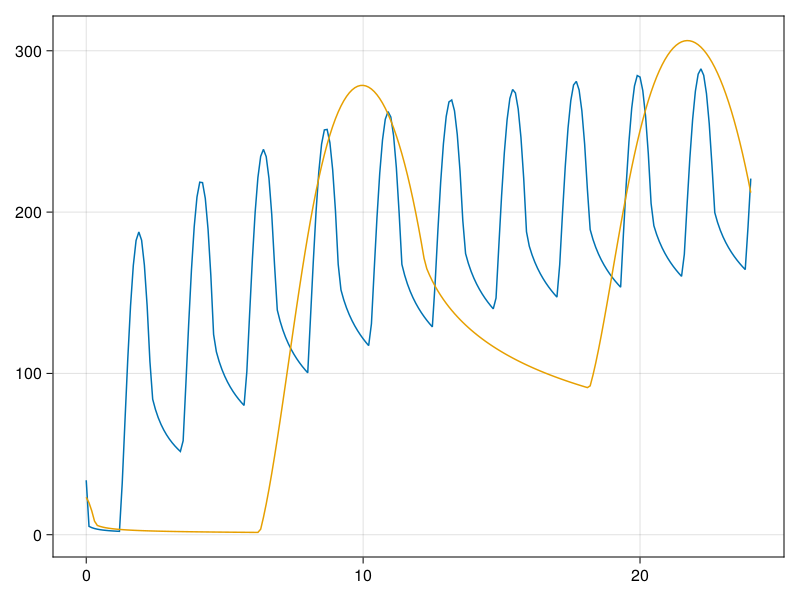

In [508]:
fig = Figure()
ax = Axis(fig[1, 1])

ts = @. (data["et_range"] - data["et_range"][begin]) / 3600

surf_temps_1 = data["surf_temps"][1][302, :]  # At equator
surf_temps_2 = data["surf_temps"][2][528, :]  # At equator

lines!(ts, surf_temps_1)
lines!(ts, surf_temps_2)

display(fig)

Max. temperature: 265.77185660150167
Min. temperature: 0.0004731064571980362


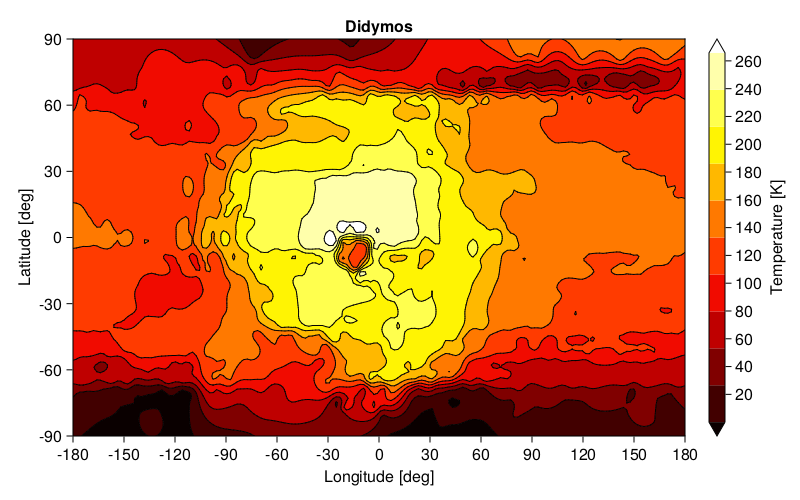

In [60]:
temps1 = data["surf_temps"][1][:, 114]
temperature_map(shape1, temps1; nlevels=10, title="Didymos")

Max. temperature: 287.3727943786986
Min. temperature: 0.0


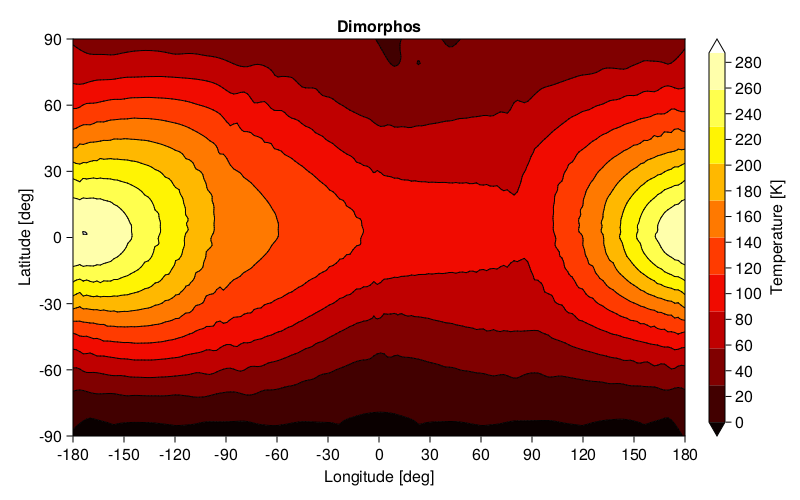

In [61]:
temps2 = data["surf_temps"][2][:, 114]
temperature_map(shape2, temps2; nlevels=10, title="Dimorphos")

Max. temperature: 287.3727943786986
Min. temperature: 0.0


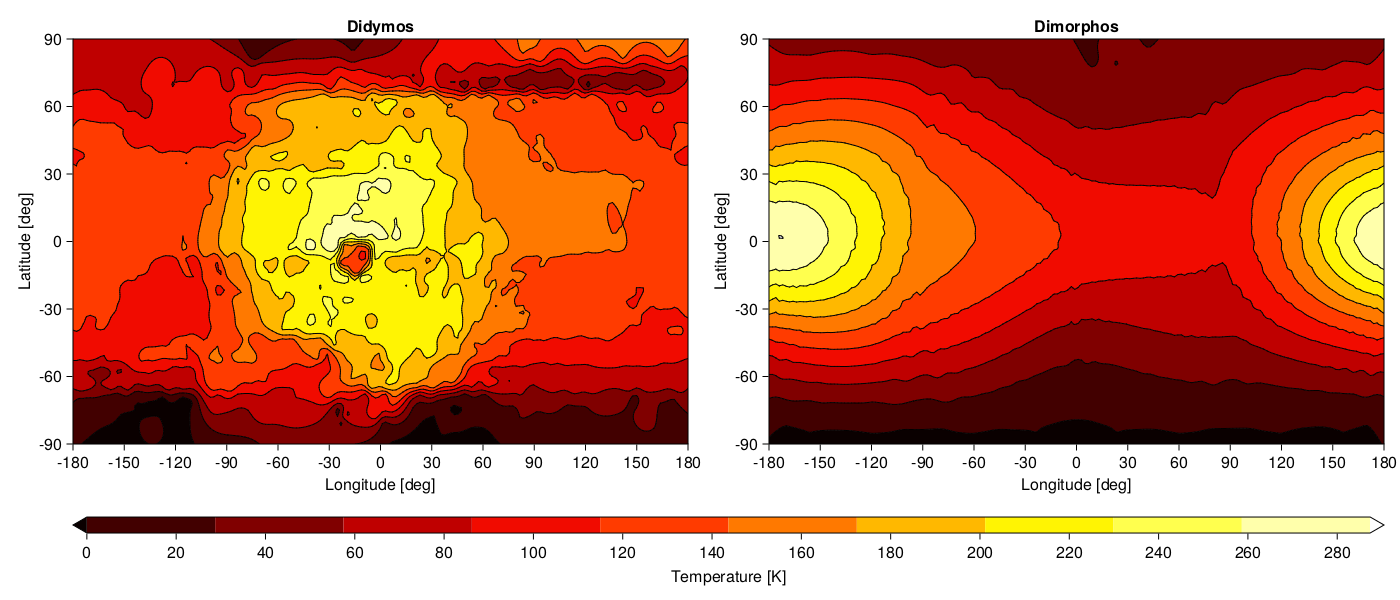

In [69]:
temperature_map(shapes..., temps1, temps2; nlevels=10, titles=("Didymos", "Dimorphos"))

In [64]:
# draw(shape1; data=temps1, colormap=:hot, strokewidth=0)
# draw(shape2; data=temps2, colormap=:hot, strokewidth=0)

In [671]:
# for (i, et) in enumerate(data["et_range"])
#     temps1 = data["surf_temps"][1][:, i]
#     temps2 = data["surf_temps"][2][:, i]
#     filepath = "./tmp/temp_maps/temp_maps_" * string(et) * ".png"
#     titles = (
#         "2027-02-09T22:00:00 + " * string((et - et_start)/3600) * " h",
#         "2027-02-09T22:00:00 + " * string((et - et_start)/3600) * " h",
#     )
#     temperature_map(shape1, shape2, temps1, temps2; colorrange=(0,350), nlevels=10, filepath, titles)
# end

- raycastの調整(主星と衛星の両方の蝕検出ができるように)

In [68]:
shapes isa Tuple

true

In [ ]:
function run_binary_TPM!(binary, thermo_params)
    @unpack shape1, shape2, orbit, mutual_orbit, spin1, spin2 = binary
    @unpack t_bgn, Δt, t_end, P = thermo_params

    init_temps_zero!(shape1, thermo_params)
    init_temps_zero!(shape2, thermo_params)

    ts = (t_bgn:Δt:t_end) * P
    df = DataFrame(
        t=Float64[], u=Float64[], ν=Float64[],
        f1_x=Float64[], f1_y=Float64[], f1_z=Float64[],
        τ1_x=Float64[], τ1_y=Float64[], τ1_z=Float64[],
        f2_x=Float64[], f2_y=Float64[], f2_z=Float64[],
        τ2_x=Float64[], τ2_y=Float64[], τ2_z=Float64[],
    )
    T₁ = Vector{Float64}[]
    T₂ = Vector{Float64}[]
    
    for t in ts
        update!(binary, t)
        
        r̂☉ = normalize(orbit.r) * -1  # Shift the origin from the sun to the body
        r̂☉₁ = orbit_to_body(r̂☉, spin1)
        r̂☉₂ = orbit_to_body(r̂☉, spin2)
        
        update_flux_sun!(shape1, orbit.F☉, r̂☉₁)
        update_flux_scat_single!(shape1, thermo_params)
        update_flux_rad_single!(shape1, thermo_params)
        
        update_flux_sun!(shape2, orbit.F☉, r̂☉₂)
        update_flux_scat_single!(shape2, thermo_params)
        update_flux_rad_single!(shape2, thermo_params)

        #### Mutual shadowing check ####
        ## Assuming the poles of rotation and mutual orbit coincide

        r̂☉ = rotateZ(r̂☉₁, -spin1.ϕ)  # Sun's direction in the mutable orbit frame
        # r̂☉ = rotateZ(r̂☉₂, -spin2.ϕ)

        r̂₁ = normalize(mutual_orbit.r₁)
        r̂₂ = normalize(mutual_orbit.r₂)
        sep1 = acos(r̂₁ ⋅ r̂☉)
        sep2 = acos(r̂₂ ⋅ r̂☉)
        
        if (t > 100 * spin2.P) && (rad2deg(min(sep1, sep2)) < 20)
            # println(t, ", ", rad2deg(sep1), ", ", rad2deg(sep2))

            for f₁ in shape1.facets
                ## Into the mutable orbit frame
                A₁ = rotateZ(f₁.A, -spin1.ϕ) + mutual_orbit.r₁
                B₁ = rotateZ(f₁.B, -spin1.ϕ) + mutual_orbit.r₁
                C₁ = rotateZ(f₁.C, -spin1.ϕ) + mutual_orbit.r₁
                center1 = rotateZ(f₁.center, -spin1.ϕ) + mutual_orbit.r₁
                # normal1 = rotateZ(f₁.normal, -spin1.ϕ)
                for f₂ in shape2.facets
                    ## Into the mutable orbit frame
                    A₂ = rotateZ(f₂.A, -spin2.ϕ) + mutual_orbit.r₂
                    B₂ = rotateZ(f₂.B, -spin2.ϕ) + mutual_orbit.r₂
                    C₂ = rotateZ(f₂.C, -spin2.ϕ) + mutual_orbit.r₂
                    center2 = rotateZ(f₂.center, -spin2.ϕ) + mutual_orbit.r₂
                    # normal2 = rotateZ(f₂.normal, -spin2.ϕ)

                    raycast(A₂ - center1, B₂ - center1, C₂ - center1, r̂☉) && (f₁.flux.sun = 0)
                    raycast(A₁ - center2, B₁ - center2, C₁ - center2, r̂☉) && (f₂.flux.sun = 0)
                end
            end
        end

        #### Mutual heating check ####
        ## Ignored for now

        update_force!(shape1, thermo_params)
        update_force!(shape2, thermo_params)
        sum_force_torque!(shape1)
        sum_force_torque!(shape2)

        f1 = body_to_orbit(SVector{3}(shape1.force),  spin1)  # Orbital plane frame
        τ1 = body_to_orbit(SVector{3}(shape1.torque), spin1)  # Orbital plane frame

        f2 = body_to_orbit(SVector{3}(shape2.force),  spin2)  # Orbital plane frame
        τ2 = body_to_orbit(SVector{3}(shape2.torque), spin2)  # Orbital plane frame
        
        update_temps!(shape1, thermo_params)
        update_temps!(shape2, thermo_params)

        push!(df, (t, orbit.u, orbit.ν, f1..., τ1..., f2..., τ2...))

        push!(T₁, surface_temperature(shape1))
        push!(T₂, surface_temperature(shape2))
    end
    df, T₁, T₂
end